<a href="https://colab.research.google.com/github/YMGYM/TSE_Learning/blob/master/garbage_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info

This is my parctice file which train a Deep-learning model

I used CNN layers, and dataset is from [here](https://www.kaggle.com/asdasdasasdas/garbage-classification)

# Import dataset and preprocessing

## unzip and load

In [ ]:
!unzip -q /content/drive/My\ Drive/Datasets/garbage.zip  -d ./dataset

In [ ]:
import pathlib

data_dir = pathlib.Path('/content/dataset/garbage classification/Garbage classification')
num_of_images = len(list(data_dir.glob('*/*.jpg')))

print(num_of_images)

2527


## Get classes name

In [ ]:
import numpy as np

CLASSES = [item.name for item in data_dir.glob('*')]
np_classes = np.array(CLASSES)
CLASSES

['plastic', 'cardboard', 'paper', 'glass', 'metal', 'trash']

## Import Keras and DataGenerator

In [ ]:
import tensorflow.keras as K

In [ ]:
image_generator = K.preprocessing.image.ImageDataGenerator(rotation_range=180, horizontal_flip=True, vertical_flip=True, rescale= 1.0/255.0 )

In [ ]:
BATCH_SIZE = 512
IMAGE_HEIGHT = 250
IMAGE_WIDTH = 250

In [ ]:
generated_train_data = image_generator.flow_from_directory(directory=data_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), class_mode='categorical', classes=CLASSES, batch_size=BATCH_SIZE, shuffle=True)

Found 2527 images belonging to 6 classes.


## Show Image

In [ ]:
import matplotlib.pyplot as plt

def show_image(image_batch, label_batch):
  plt.figure(figsize = (10,10))
  for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(np_classes[label_batch[n] == 1][0].title())
    plt.axis('off')

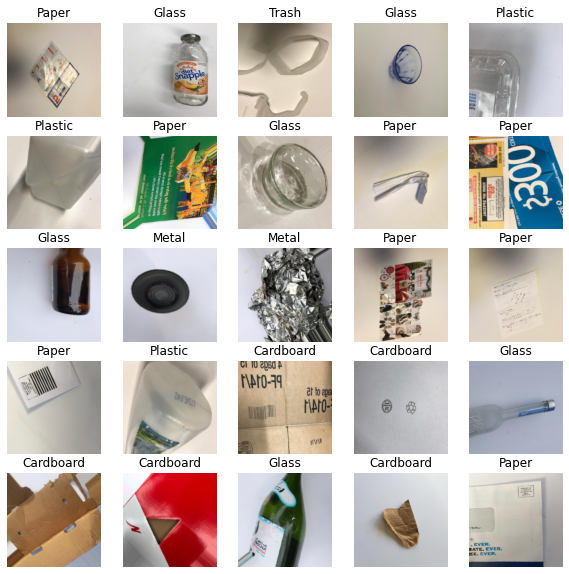

In [ ]:
image_batch, label_batch = generated_train_data[0]
show_image(image_batch, label_batch)

In [ ]:
image_batch[0].shape

(250, 250, 3)

In [ ]:
label_batch[5].shape

(6,)

# Model Import

가장 기본적인 LeNet-5 을 조금 변형

In [ ]:
DROPOUT_RATE = 0.1

In [ ]:
model_input_layer = K.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
cnn_1 = K.layers.Conv2D(filters=6, kernel_size=(6,6), activation="relu")(model_input_layer)
pool_1 = K.layers.MaxPool2D()(cnn_1)
drop_1 = K.layers.Dropout(DROPOUT_RATE)(pool_1)
flatten = K.layers.Flatten()(drop_1)

dense_1 = K.layers.Dense(1000, activation='relu')(flatten)
drop_3 = K.layers.Dropout(DROPOUT_RATE)(dense_1)
dense_2 = K.layers.Dense(100, activation='relu')(drop_3)
model_output_layer = K.layers.Dense(len(CLASSES), activation="softmax")(drop_3)

model = K.Model(inputs=model_input_layer, outputs=model_output_layer)



In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 245, 245, 6)       654       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 122, 122, 6)       0         
_________________________________________________________________
dropout (Dropout)            (None, 122, 122, 6)       0         
_________________________________________________________________
flatten (Flatten)            (None, 89304)             0         
_________________________________________________________________
dense (Dense)                (None, 1000)              89305000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)             

In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
EPOCHS = 100

In [ ]:
model.fit(generated_train_data, epochs=EPOCHS)

Epoch 1/100
20/20 [==============================] - 35s 2s/step - loss: 15.7690 - accuracy: 0.2667
Epoch 2/100
20/20 [==============================] - 37s 2s/step - loss: 1.6479 - accuracy: 0.3158
Epoch 3/100
20/20 [==============================] - 37s 2s/step - loss: 1.6094 - accuracy: 0.3383
Epoch 4/100
20/20 [==============================] - 36s 2s/step - loss: 1.5715 - accuracy: 0.3720
Epoch 5/100
20/20 [==============================] - 37s 2s/step - loss: 1.5400 - accuracy: 0.3748
Epoch 6/100
20/20 [==============================] - 36s 2s/step - loss: 1.5387 - accuracy: 0.3736
Epoch 7/100
20/20 [==============================] - 37s 2s/step - loss: 1.5344 - accuracy: 0.3605
Epoch 8/100
20/20 [==============================] - 36s 2s/step - loss: 1.4971 - accuracy: 0.3839
Epoch 9/100
20/20 [==============================] - 36s 2s/step - loss: 1.5196 - accuracy: 0.3910
Epoch 10/100
20/20 [==============================] - 36s 2s/step - loss: 1.4724 - accuracy: 0.3934
Epoch 11

In [ ]:
np_classes

array(['plastic', 'cardboard', 'paper', 'glass', 'metal', 'trash'],
      dtype='<U9')

In [40]:
def show_predict_image(image_batch, label_batch):
  plt.figure(figsize = (30,30))
  for n in range(100):
    ax = plt.subplot(10, 10, n+1)
    plt.imshow(image_batch[n])
    prediction = model.predict(image_batch[n:n+1]).argmax()
    if prediction != 5:
      plt.title(np_classes[prediction] + "/" + np_classes[label_batch[n] == 1][0].title())
    else:
      plt.title(np_classes[prediction] + "/" + np_classes[label_batch[n] == 1][0].title())
    # plt.title(np_classes[prediction]) # 조금 더 상세히..
    plt.axis('off')

In [37]:
i, l = generated_train_data[4]

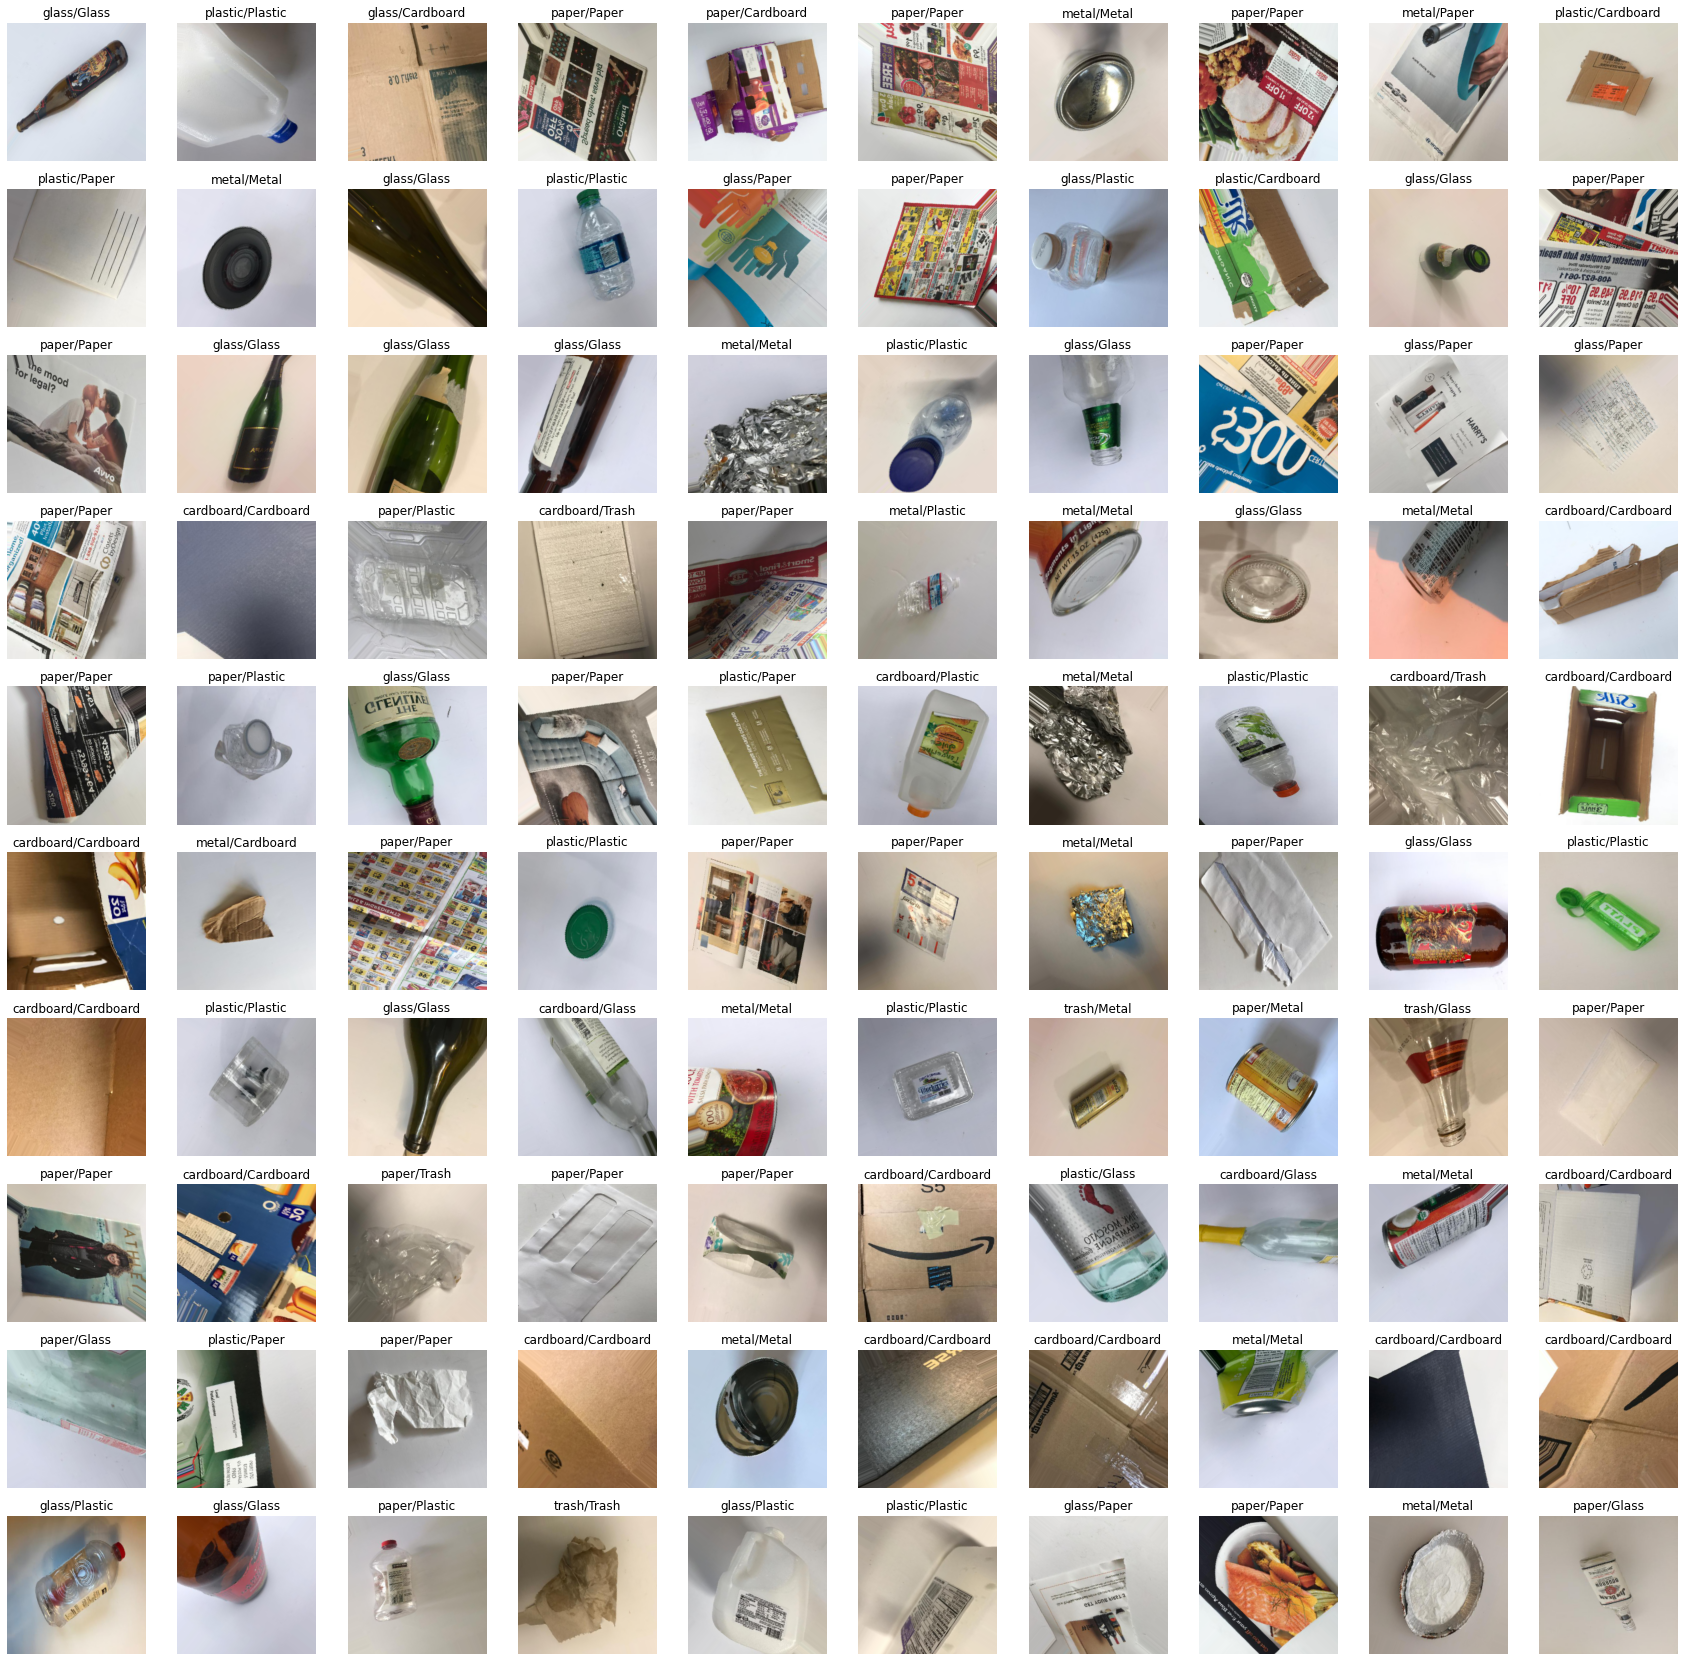

In [41]:
show_predict_image(i, l)